# 朴素贝叶斯之新浪新闻分类(Sklearn)

## 1 准备数据, 生成词汇表

In [23]:
import os
import jieba
import random
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

In [9]:
# 将所有的单词生成词汇表
# 读入所有文件以及label, 将读进来的数据分成训练集和测试集
# 利用训练集中的数据生成词汇表, 并按单词出现的数量由高到底进行排序
# 返回词汇表, 训练集, 测试集, 训练label, 测试label
def TextProcessing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)   # 存放所有数据的主文件夹路径
    data_list = []
    class_list = []
    for folder in folder_list:             # 遍历主文件夹下的每一个文件夹, 也就是每一个类别
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path) # 当前文件夹下的所有文件
        j = 1
        for file in files:
            if j > 100:
                break
            with open(os.path.join(new_folder_path, file), 'r', encoding='utf-8') as f:
                raw = f.read()
            word_cut = jieba.cut(raw, cut_all=False)     # 分词
            word_list = list(word_cut)                   
            data_list.append(word_list)
            class_list.append(folder)
            j+=1
#     print(data_list)
#     print(class_list)    
    #      
    data_class_list = list(zip(data_list, class_list))  # 将文件和对应的列表压缩在一起
    random.shuffle(data_class_list)                     
    index = int(len(data_class_list) * test_size) + 1   # 测试集的文件个数
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list, train_class_list = zip(*train_list) # 解压缩, 分成文件和对应的label
    test_data_list, test_class_list = zip(*test_list)
    # 统计每一个单词的个数 生成键值对{'单词': num}
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict.keys():
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) # 对值由高到底排序
    all_word_list, all_word_nums = zip(*all_words_tuple_list)
    all_word_list = list(all_word_list)
    return all_word_list, train_data_list, test_data_list, train_class_list, test_class_list


In [14]:
# 制作一个set集合, 里面存储的是一些无用的高频词
# 因为上一步生成的词汇表中有一些高频词是: 标点符号, '的 地 得', 以及数字, 我们要将这些去掉
# 所以提前准备了一个文件, 里面包含要去掉的单词
def makeWordSet(words_file):
    word_set = set()
    with open(words_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            word = line.strip()     # 去掉这一行的空格
            if len(word) > 0: 
                word_set.add(word)  # 放入set集合
    return word_set

In [52]:
# 将词汇表中的前N个高频词去掉
# all_word_list: 词汇表 deleteN: N stopwords_set: 无用词汇集合
# 该函数直接不考虑词汇表中的前0-deleteN-1个单词, 从第deleteN开始逐一判断每一个单词是否符合保留的条件
# 符合的话就放入feature_words中, 不符合就抛弃, 生成新的词汇表
# 返回: 新的词汇表
def words_dict(all_word_list, deleteN, stopwords_set = set()):
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_word_list), 1):
        if n > 1000:
            break
        if not all_word_list[t].isdigit() and all_word_list[t] not in stopwords_set and 1 < len(all_word_list[t]) < 5:
            feature_words.append(all_word_list[t])
        n += 1
    return feature_words

In [53]:
# 文本生成特征向量
# train_data_list, test_data_list, feature_words: 训练集, 测试集, 新词汇表
# 遍历训练集中的每一个文档
#    遍历词汇表中的每一个单词, 如果这个单词出现在文档中, 就把这个位置设置为1, 否则为0
#    所以每一个单词生成的词向量长度是len(feature_words)
# 返回: 训练集词向量, 测试集词向量
def TextFeatures(train_data_list, test_data_list, feature_words):
    def text_feature(text, feature_words):
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features
    train_feature_list = [text_feature(text, feature_words) for text in train_data_list]
    test_feature_list = [text_feature(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

In [40]:
# 制作分类器
def TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list):
    classifier = MultinomialNB().fit(train_feature_list, train_class_list)
    test_accuracy = classifier.score(test_feature_list, test_class_list)
    return test_accuracy

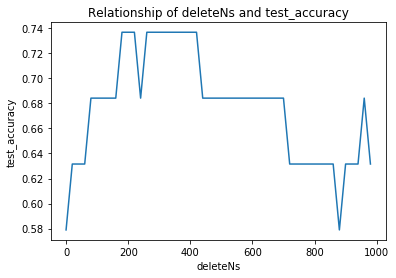

In [60]:
if __name__ == '__main__':
    folder_path = './Machine-Learning-master/Naive Bayes/SogouC/Sample'
    all_word_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path)
    stopwords_file = './Machine-Learning-master/Naive Bayes/stopwords_cn.txt'
    stopwords_set = makeWordSet(stopwords_file)
#     feature_words = words_dict(all_word_list, 100, stopwords_set)
    test_accuracy_list = []
    deleteNs = range(0, 1000, 20)
    for deleteN in deleteNs:
        feature_words = words_dict(all_word_list, deleteN, stopwords_set)
        train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
        test_accuracy = TextClassifier(train_feature_list, test_feature_list,train_class_list, test_class_list)
        test_accuracy_list.append(test_accuracy)
    plt.figure()
    plt.title('Relationship of deleteNs and test_accuracy')
    plt.plot(deleteNs, test_accuracy_list)
    plt.xlabel('deleteNs')
    plt.ylabel('test_accuracy')
    plt.show()

In [69]:
if __name__ == '__main__':
    folder_path = './Machine-Learning-master/Naive Bayes/SogouC/Sample'
    all_word_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path)
    stopwords_file = './Machine-Learning-master/Naive Bayes/stopwords_cn.txt'
    stopwords_set = makeWordSet(stopwords_file)
    
    test_accuracy_list = []
    feature_words = words_dict(all_word_list, 300, stopwords_set)
    train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
    test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list)
    test_accuracy_list.append(test_accuracy)
    ave = lambda c: sum(c) / len(c)
    
    print(ave(test_accuracy_list))
    print(test_accuracy, test_accuracy_list)

0.526315789474
0.526315789474 [0.52631578947368418]
